In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls "/content/drive/MyDrive/converted_unified"

data_cls.yaml  images  labels  YOLO_Training


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/MyDrive/converted_unified"
!find "/content/drive/MyDrive/converted_unified/images/train" -type f | wc -l
!find "/content/drive/MyDrive/converted_unified/images/val" -type f | wc -l

!cat "/content/drive/MyDrive/converted_unified/data.yaml"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data_cls.yaml  images  labels
10129
1135
cat: /content/drive/MyDrive/converted_unified/data.yaml: No such file or directory


In [ ]:
from pathlib import Path
import shutil

source = Path("/content/drive/MyDrive/converted_unified")
dest = Path("/content/data")

if dest.exists():
    shutil.rmtree(dest)

shutil.copytree(source, dest)
print("Done to /content/data ")
!ls /content/data

Done to /content/data 
data_cls.yaml  images  labels


In [ ]:
from pathlib import Path
import shutil
import random
from PIL import Image, ImageEnhance, ImageOps

ROOT = Path("/content/data")
IMG_TRAIN = ROOT / "images" / "train"
LBL_TRAIN = ROOT / "labels" / "train"

final_classes = ['arson', 'explosion', 'fighting', 'fire', 'handgun', 'knife', 'normal',
                 'rifle', 'road_accident', 'robbery', 'shooting', 'shoplifting', 'smoke', 'vandalism']
NORMAL_ID = final_classes.index("normal")

normal_images = []
for lbl_file in LBL_TRAIN.iterdir():
    if lbl_file.stat().st_size == 0:
        continue
    lines = lbl_file.read_text().splitlines()
    if any(line.split()[0] == str(NORMAL_ID) for line in lines if line.strip()):
        img_path = IMG_TRAIN / (lbl_file.stem + ".jpg")
        if not img_path.exists():
            img_path = IMG_TRAIN / (lbl_file.stem + ".png")
        if img_path.exists():
            normal_images.append((img_path, lbl_file))

print(f"num of image normal: {len(normal_images)}")

AUG_TARGET = 4000
added = 0
for i in range(AUG_TARGET):
    src_img, src_lbl = random.choice(normal_images)

    img = Image.open(src_img)

    if random.random() > 0.5: img = img.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random() > 0.5: img = img.transpose(Image.FLIP_TOP_BOTTOM)
    if random.random() > 0.5: img = ImageEnhance.Brightness(img).enhance(random.uniform(0.7, 1.3))
    if random.random() > 0.5: img = img.rotate(random.uniform(-20, 20), expand=True, resample=Image.BICUBIC)

    new_name = src_img.stem + f"_aug_{added}{src_img.suffix}"
    new_img_path = IMG_TRAIN / new_name
    new_lbl_path = LBL_TRAIN / new_name.replace(src_img.suffix, ".txt")

    img.save(new_img_path)
    shutil.copy2(src_lbl, new_lbl_path)
    added += 1
    if added % 500 == 0:
        print(f"add done{added} image augmented")

print(f"done we add {added} normal")

yaml_content = """
path: /content/data
train: images/train
val: images/val
nc: 14
names: ['arson', 'explosion', 'fighting', 'fire', 'handgun', 'knife', 'normal', 'rifle', 'road_accident', 'robbery', 'shooting', 'shoplifting', 'smoke', 'vandalism']
"""
(ROOT / "data.yaml").write_text(yaml_content)
print("data.yaml update to /content/data")

num of image normal: 55
add done500 image augmented
add done1000 image augmented
add done1500 image augmented
add done2000 image augmented
add done2500 image augmented
add done3000 image augmented
add done3500 image augmented
add done4000 image augmented
done we add 4000 normal
data.yaml update to /content/data


total normal after augmentation: 4055 


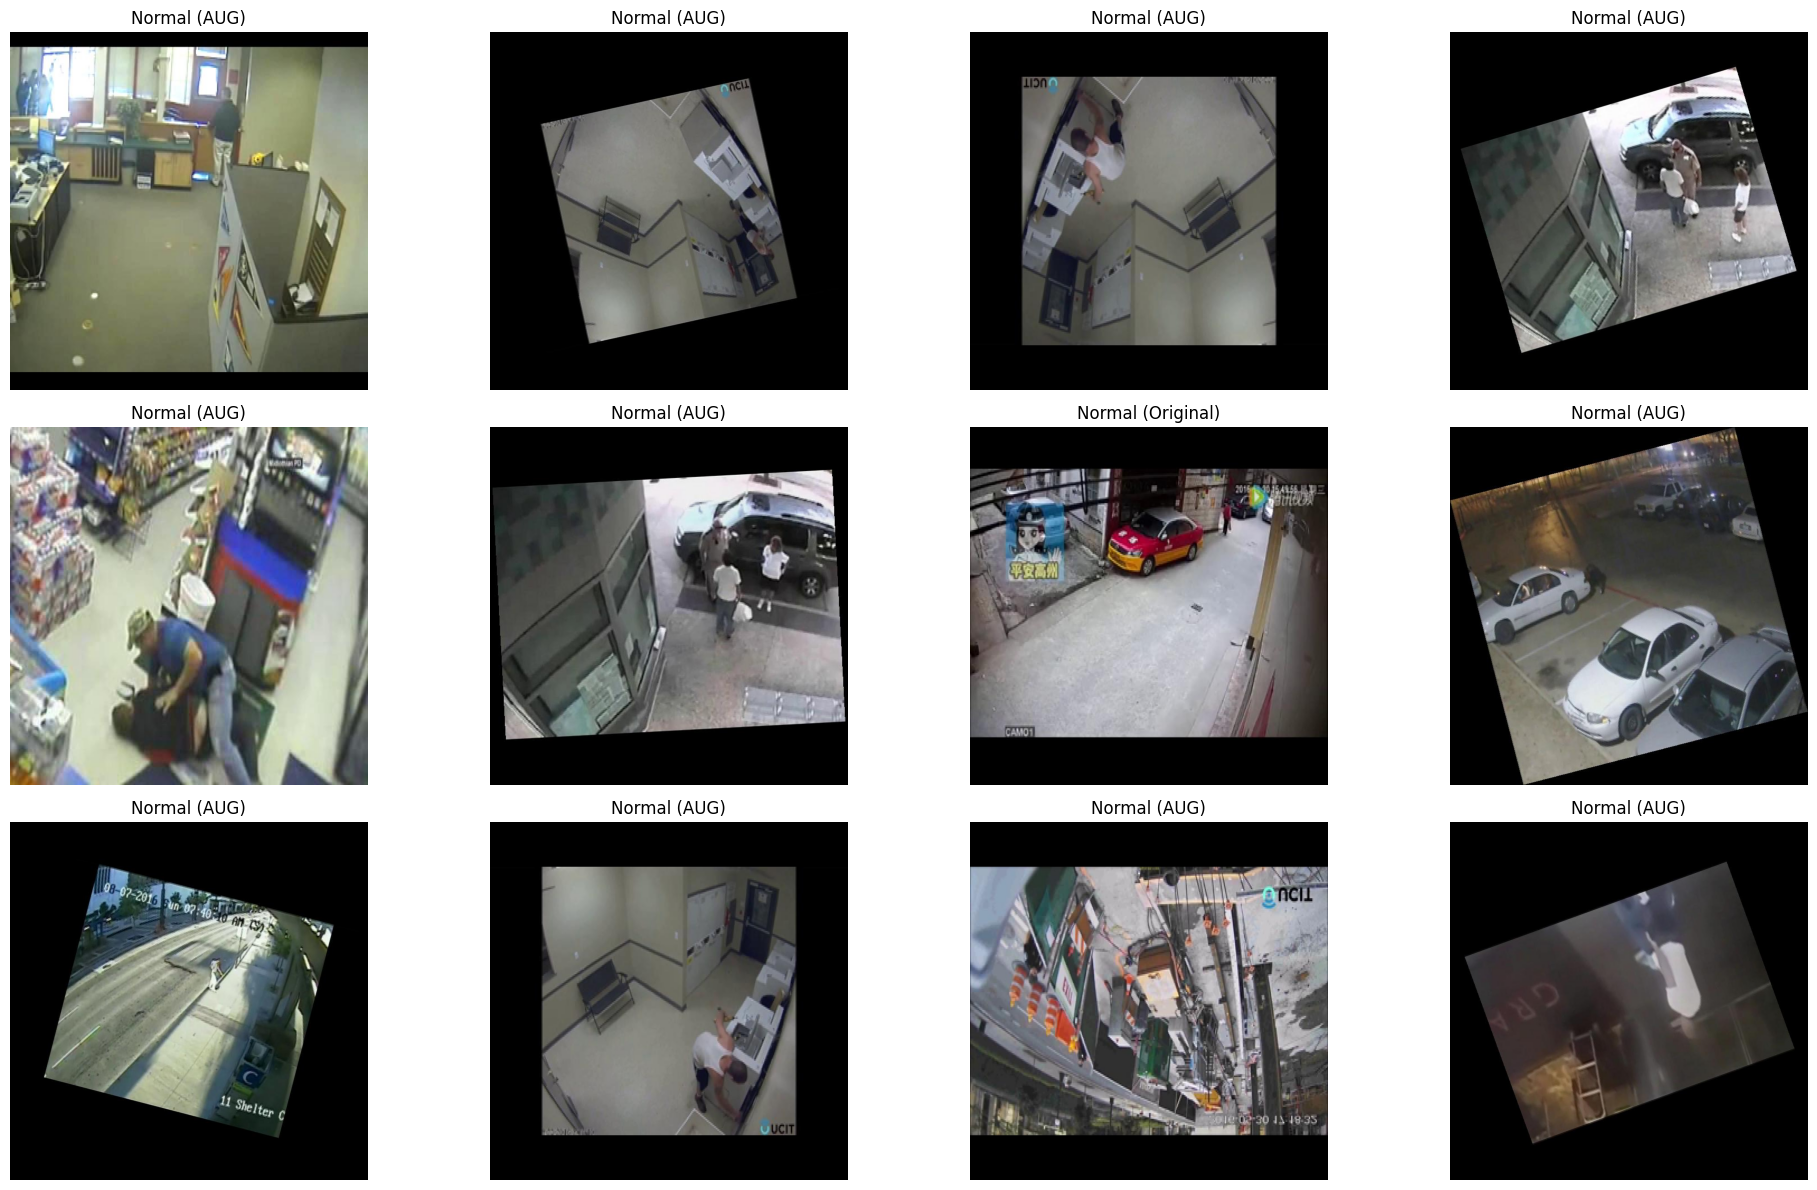

In [ ]:
import matplotlib.pyplot as plt
import random
from pathlib import Path

IMG_TRAIN = Path("/content/data/images/train")
LBL_TRAIN = Path("/content/data/labels/train")

final_classes = ['arson', 'explosion', 'fighting', 'fire', 'handgun', 'knife', 'normal',
                 'rifle', 'road_accident', 'robbery', 'shooting', 'shoplifting', 'smoke', 'vandalism']
NORMAL_ID = final_classes.index("normal")

normal_images = []
for lbl_file in LBL_TRAIN.iterdir():
    if lbl_file.suffix != ".txt": continue
    lines = lbl_file.read_text().splitlines()
    if any(line.split()[0] == str(NORMAL_ID) for line in lines if line.strip()):
        for ext in [".jpg", ".jpeg", ".png", ".bmp", ".webp"]:
            img_path = IMG_TRAIN / (lbl_file.stem + ext)
            if img_path.exists():
                normal_images.append(img_path)
                break

random.shuffle(normal_images)
samples = normal_images[:12]

print(f"total normal after augmentation: {len(normal_images)} ")

plt.figure(figsize=(20, 12))
for i, p in enumerate(samples):
    img = plt.imread(p)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"Normal {'(AUG)' if 'aug' in p.name else '(Original)'}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
!pip install ultralytics -q --upgrade



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.7 MB/s eta 0:00:00


In [ ]:
!yolo task=detect mode=train \
    model=yolov10n.pt \
    data=/content/data/data.yaml \
    epochs=150 \
    imgsz=240 \
    batch=32 \
    patience=40 \
    project=/content/drive/MyDrive/YOLO_Training \
    name="final_detection_14class_balanced" \
    pretrained=True \
    exist_ok=True \
    verbose=True

Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=240, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=final_detection_14class_balanced, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=40, perspective=0

In [ ]:
import torch
torch.cuda.is_available()


False

In [ ]:
from pathlib import Path
import shutil

source = Path("/content/drive/MyDrive/converted_unified")
dest = Path("/content/data")

if dest.exists():
    shutil.rmtree(dest)

shutil.copytree(source, dest)
print("Without oversampling")

Without oversampling


In [ ]:
!yolo task=detect mode=train \
    model=/content/drive/MyDrive/YOLO_Training/final_detection_14class_balanced/weights/last.pt \
    data=/content/data/data.yaml \
    epochs=150 \
    imgsz=240 \
    batch=32 \
    patience=40 \
    project=/content/drive/MyDrive/YOLO_Training \
    name=final_detection_14class_balanced \
    resume=True \
    pretrained=False \
    exist_ok=True \
    verbose=True

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.0 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/YOLO_Training/final_detection_14class_balanced/weights/best.pt")

print(model.names)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
{0: 'arson', 1: 'explosion', 2: 'fighting', 3: 'fire', 4: 'handgun', 5: 'knife', 6: 'normal', 7: 'rifle', 8: 'road_accident', 9: 'robbery', 10: 'shooting', 11: 'shoplifting', 12: 'smoke', 13: 'vandalism'}



image 1/1 /content/drive/MyDrive/converted_unified/images/val/fire2_mp4-47_jpg.rf.d45cef703b1911d102951e8b6acb4188.jpg: 256x256 1 fire, 82.8ms
Speed: 1.2ms preprocess, 82.8ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


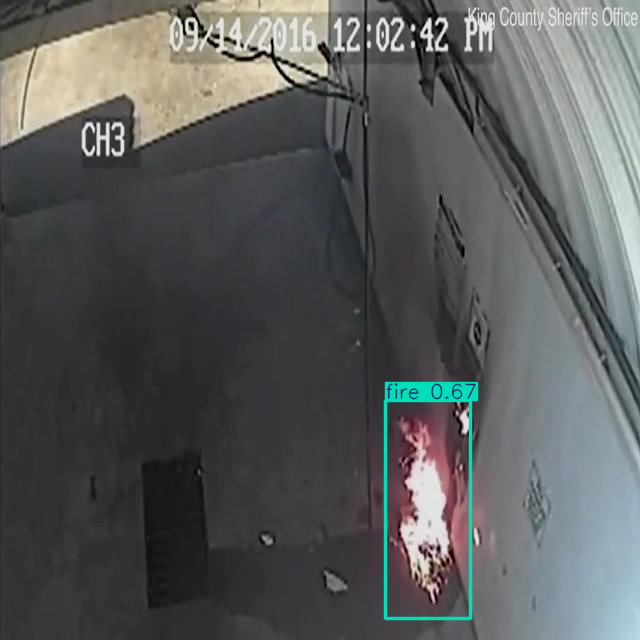

'results_fire2_mp4-47_jpg.rf.d45cef703b1911d102951e8b6acb4188.jpg'

In [ ]:
results = model("/content/drive/MyDrive/converted_unified/images/val/fire2_mp4-47_jpg.rf.d45cef703b1911d102951e8b6acb4188.jpg")  # غيّر اسم الصورة

results[0].show()
results[0].save()

In [ ]:
!yolo predict model="/content/drive/MyDrive/YOLO_Training/final_detection_14class_balanced/weights/best.pt" source="https://www.youtube.com/watch?v=OOsxdDss-uE" save=True show=True

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
YOLOv10n summary (fused): 102 layers, 2,267,898 parameters, 0 gradients, 6.5 GFLOPs

1/1: https://www.youtube.com/watch?v=OOsxdDss-uE... Success ✅ (14746 frames of shape 1920x1080 at 30.00 FPS)

0: 160x256 (no detections), 121.0ms
0: 160x256 1 fire, 91.6ms
0: 160x256 (no detections), 67.7ms
0: 160x256 (no detections), 58.0ms
0: 160x256 (no detections), 61.1ms
0: 160x256 (no detections), 86.3ms
0: 160x256 (no detections), 65.9ms
0: 160x256 (no detections), 75.5ms
0: 160x256 (no detections), 64.9ms
0: 160x256 (no detections), 81.7ms
0: 160x256 (no detections), 121.4ms
0: 160x256 (no detections), 161.0ms
0: 160x256 (no detections), 200.1ms
0: 160x256 (no detections), 74.5ms
0: 160x256 (no detections), 113.5ms
0: 160x256 (no detections), 153.6ms
0: 160x256 (no detections), 156.5ms
0: 160x256 (no detections), 173.8ms
0: 160x256 (no d

**Final Training**

In [3]:
from pathlib import Path
import shutil

source = Path("/content/drive/MyDrive/converted_unified")
dest = Path("/content/data")

if dest.exists():
    shutil.rmtree(dest)

shutil.copytree(source, dest)


PosixPath('/content/data')

In [4]:
!pip install ultralytics -q --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.4 MB/s eta 0:00:00


In [5]:
import torch
torch.cuda.is_available()


True

In [6]:
!mkdir -p /content/data

yaml_content = """
path: /content/data
train: images/train
val: images/val
nc: 14
names: ['arson', 'explosion', 'fighting', 'fire', 'handgun', 'knife', 'normal', 'rifle', 'road_accident', 'robbery', 'shooting', 'shoplifting', 'smoke', 'vandalism']
"""

import yaml
with open("/content/data/data.yaml", "w") as f:
    f.write(yaml_content)

!cat /content/data/data.yaml

!yolo task=detect mode=train \
    model="/content/drive/MyDrive/YOLO_Training/New_Weights/weights/last.pt" \
    data=/content/data/data.yaml \
    epochs=200 \
    imgsz=640 \
    batch=32 \
    patience=50 \
    project="/content/drive/MyDrive/YOLO_Training" \
    name="New_Weights" \
    resume=True \
    verbose=True


path: /content/data
train: images/train
val: images/val
nc: 14
names: ['arson', 'explosion', 'fighting', 'fire', 'handgun', 'knife', 'normal', 'rifle', 'road_accident', 'robbery', 'shooting', 'shoplifting', 'smoke', 'vandalism']
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0,


0: 640x640 4 fires, 1 smoke, 7.7ms
1: 640x640 3 fires, 7.7ms
2: 640x640 1 handgun, 7.7ms
3: 640x640 1 smoke, 7.7ms
4: 640x640 1 handgun, 7.7ms
5: 640x640 1 rifle, 7.7ms
6: 640x640 2 fires, 1 smoke, 7.7ms
7: 640x640 1 rifle, 7.7ms
8: 640x640 1 rifle, 7.7ms
9: 640x640 2 handguns, 4 knifes, 3 rifles, 7.7ms
Speed: 4.0ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


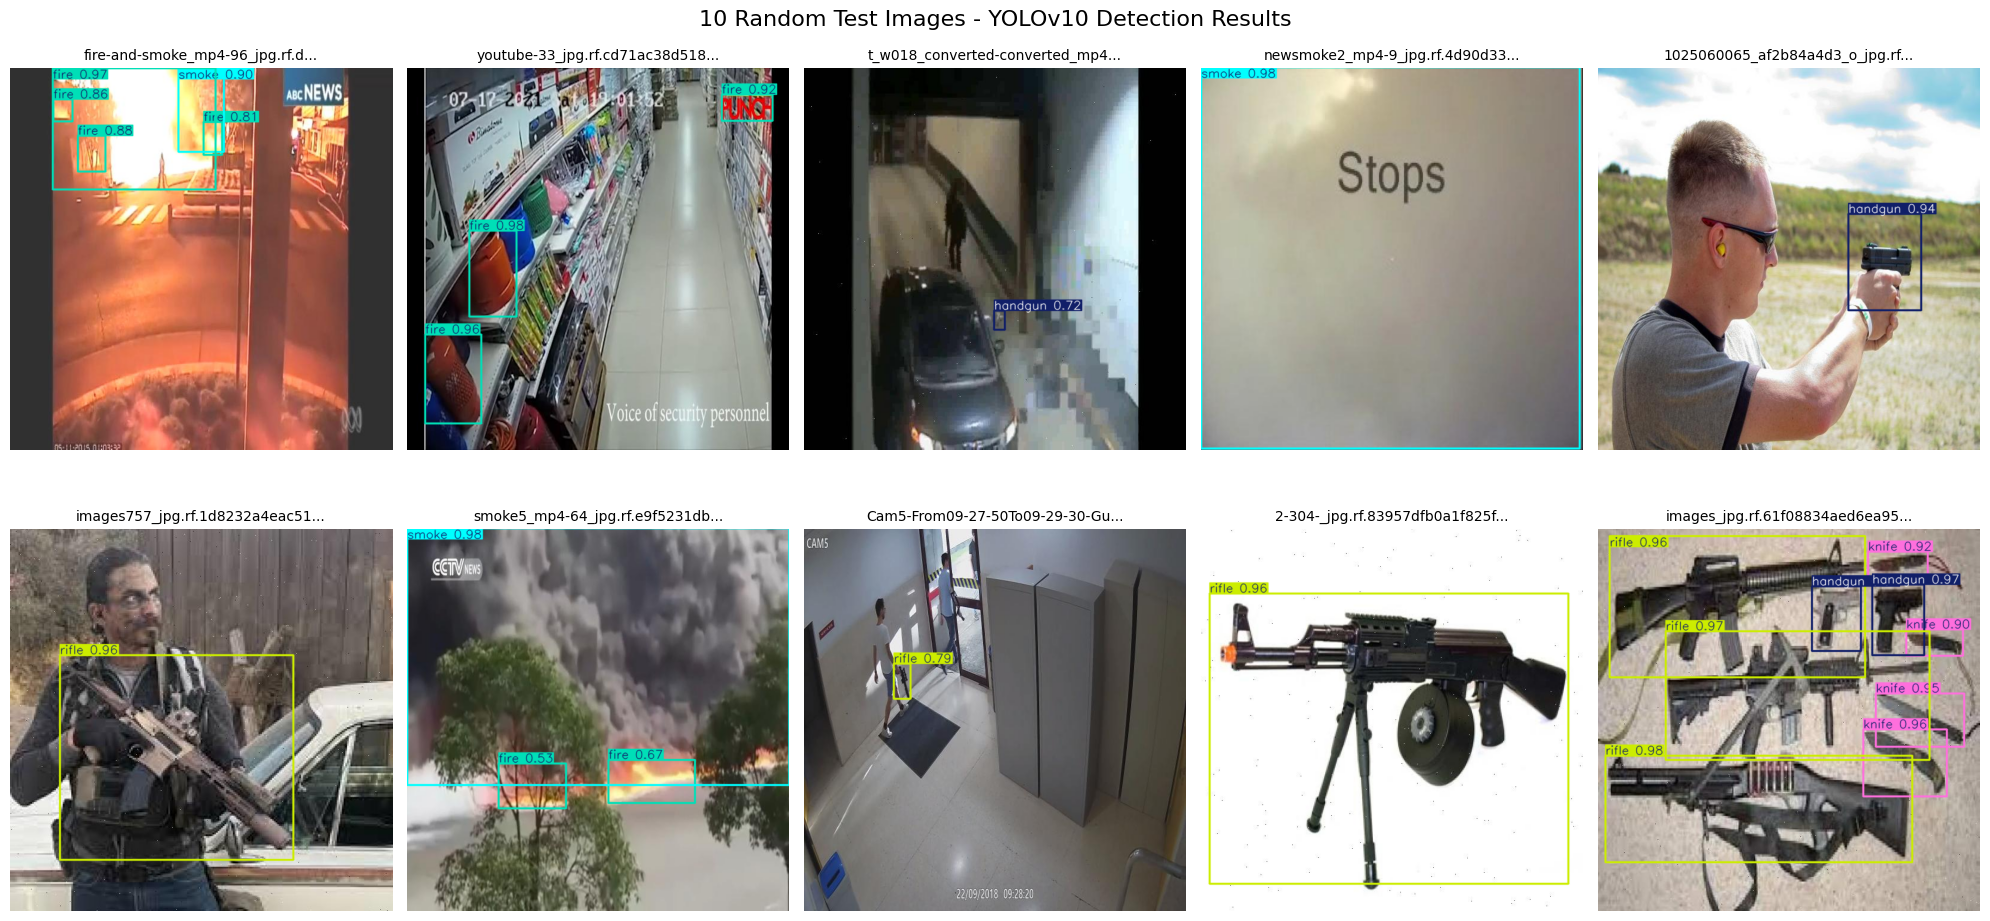

The image has been saved in your Drive: test_10_images_result.jpg


<Figure size 640x480 with 0 Axes>

In [7]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2
import numpy as np

# Load the model
model = YOLO("/content/drive/MyDrive/YOLO_Training/New_Weights/weights/best.pt")

# Select 10 random images from train
image_dir = Path("/content/data/images/val")
all_images = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))
random.shuffle(all_images)
selected = all_images[:10]

# Run prediction on the 10 images
results = model(selected, imgsz=640, conf=0.25)

# Prepare a 2×5 grid
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i, (img_path, result) in enumerate(zip(selected, results)):
    # Read the original image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes from the result
    annotated = result.plot()  # This returns the image with boxes
    annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

    # Display the image
    axes[i].imshow(annotated)
    axes[i].set_title(f"{img_path.name[:30]}...", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle("10 Random Test Images - YOLOv10 Detection Results", fontsize=16, y=0.98)
plt.show()

# Save the final big image in Google Drive
plt.savefig("/content/drive/MyDrive/test_10_images_result.jpg", dpi=300, bbox_inches='tight')
print("The image has been saved in your Drive: test_10_images_result.jpg")



0: 640x640 (no detections), 6.0ms
1: 640x640 6 fires, 6.0ms
2: 640x640 1 handgun, 1 knife, 1 rifle, 6.0ms
3: 640x640 1 knife, 6.0ms
4: 640x640 1 knife, 6.0ms
5: 640x640 1 fighting, 6.0ms
6: 640x640 2 handguns, 1 knife, 2 rifles, 6.0ms
7: 640x640 2 knifes, 6.0ms
8: 640x640 1 handgun, 6.0ms
9: 640x640 1 fighting, 6.0ms
Speed: 13.3ms preprocess, 6.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


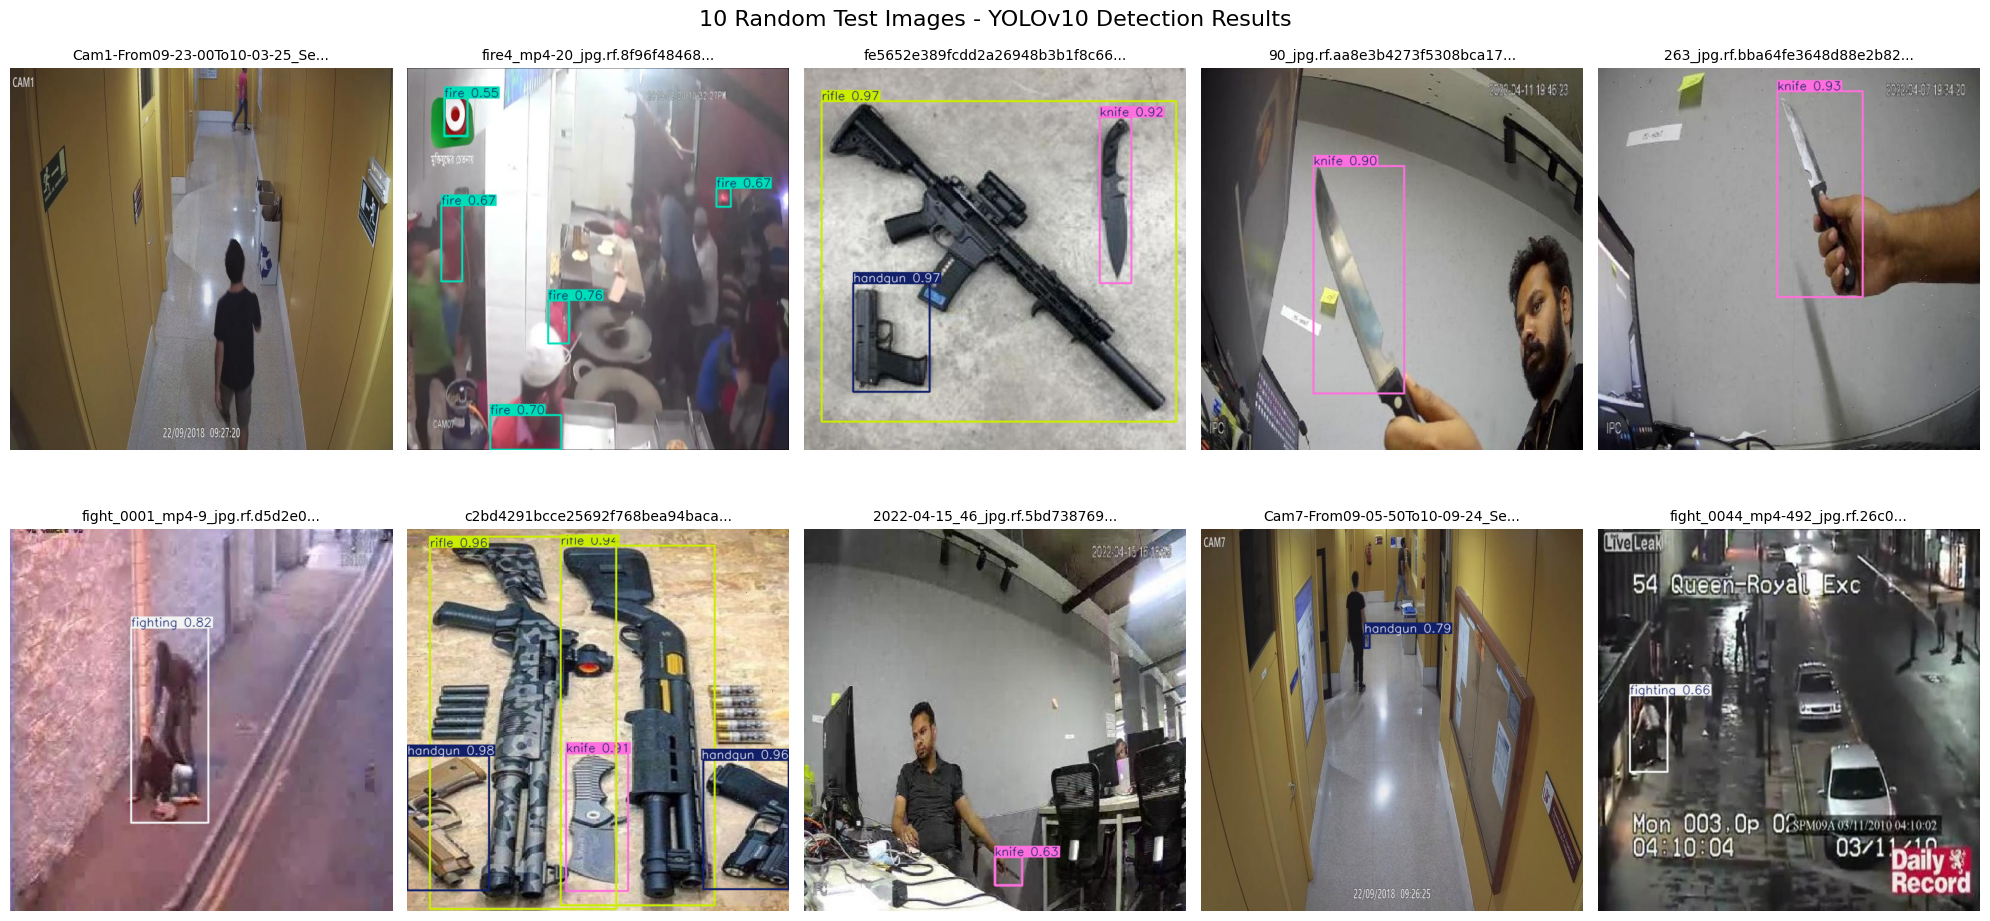

The image has been saved in your Drive: test_10_images_result.jpg


<Figure size 640x480 with 0 Axes>

In [8]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2
import numpy as np

# Load the model
model = YOLO("/content/drive/MyDrive/YOLO_Training/New_Weights/weights/best.pt")

# Select 10 random images from train
image_dir = Path("/content/data/images/val")
all_images = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))
random.shuffle(all_images)
selected = all_images[:10]

# Run prediction on the 10 images
results = model(selected, imgsz=640, conf=0.25)

# Prepare a 2×5 grid
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i, (img_path, result) in enumerate(zip(selected, results)):
    # Read the original image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes from the result
    annotated = result.plot()  # This returns the image with boxes
    annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

    # Display the image
    axes[i].imshow(annotated)
    axes[i].set_title(f"{img_path.name[:30]}...", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle("10 Random Test Images - YOLOv10 Detection Results", fontsize=16, y=0.98)
plt.show()

# Save the final big image in Google Drive
plt.savefig("/content/drive/MyDrive/test_10_images_result.jpg", dpi=300, bbox_inches='tight')
print("The image has been saved in your Drive: test_10_images_result.jpg")


In [10]:
!yolo predict \
    model="/content/drive/MyDrive/YOLO_Training/final_detection_14class_balanced/weights/best.pt" \
    source="/content/Arson001_x264.mp4" \
    imgsz=640 \
    conf=0.3 \
    save=True \
    line_width=3

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,267,898 parameters, 0 gradients, 6.5 GFLOPs

video 1/1 (frame 1/4187) /content/Arson001_x264.mp4: 480x640 (no detections), 59.3ms
video 1/1 (frame 2/4187) /content/Arson001_x264.mp4: 480x640 (no detections), 7.7ms
video 1/1 (frame 3/4187) /content/Arson001_x264.mp4: 480x640 (no detections), 7.5ms
video 1/1 (frame 4/4187) /content/Arson001_x264.mp4: 480x640 (no detections), 8.3ms
video 1/1 (frame 5/4187) /content/Arson001_x264.mp4: 480x640 (no detections), 9.4ms
video 1/1 (frame 6/4187) /content/Arson001_x264.mp4: 480x640 1 fire, 7.4ms
video 1/1 (frame 7/4187) /content/Arson001_x264.mp4: 480x640 1 fire, 16.3ms
video 1/1 (frame 8/4187) /content/Arson001_x264.mp4: 480x640 1 fire, 7.5ms
video 1/1 (frame 9/4187) /content/Arson001_x264.mp4: 480x640 1 fire, 7.4ms
video 1/1 (frame 10/4187) /content/Arson001_x264.mp4: 480x640 (no detections), 7.9ms
video 1/1 (frame 11/4187)

In [12]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/YOLO_Training/New_Weights/weights/best.pt")

metrics = model.val(
    data="/content/data/data.yaml",
    imgsz=640,
    batch=32,
    device=0 if torch.cuda.is_available() else "cpu",
    plots=True,
    save_json=True,
    verbose=True
)

print("\n" + "="*60)
print("               FINAL MODEL ACCURACY")
print("="*60)
print(f"Precision         : {metrics.box.p.mean():.3f}")
print(f"Recall            : {metrics.box.r.mean():.3f}")
print(f"mAP50             : {metrics.box.ap50.mean():.3f}")
print(f"mAP50-95 (final)  : {metrics.box.map:.3f}  ← important")
print("="*60)



Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,267,898 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1122.2±327.1 MB/s, size: 27.1 KB)
val: Scanning /content/data/labels/val.cache... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 2.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 36/36 2.6it/s 14.0s
                   all       1135       2016      0.793      0.758      0.793      0.485
                 arson          6          6      0.551      0.819      0.662      0.204
             explosion          3          3      0.765      0.667      0.715      0.244
              fighting        148        156      0.788      0.769      0.827      0.506
                  fire        236        598      0.902       0.91      0.952      0.727
               handgun        186        281   

In [15]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/YOLO_Training/New_Weights/weights/best.pt")

metrics = model.val(
    data="/content/data/data.yaml",
    imgsz=640,
    batch=32,
    plots=True,
    save=True,
    project="/content/runs/val",
    name="final_results_with_plots",
    exist_ok=True
)

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,267,898 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1197.3±436.2 MB/s, size: 38.6 KB)
val: Scanning /content/data/labels/val.cache... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 562.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 36/36 2.8it/s 13.0s
                   all       1135       2016      0.793      0.758      0.793      0.485
                 arson          6          6      0.551      0.819      0.662      0.204
             explosion          3          3      0.765      0.667      0.715      0.244
              fighting        148        156      0.788      0.769      0.827      0.506
                  fire        236        598      0.902       0.91      0.952      0.727
               handgun        186        281 

founded: confusion_matrix.png


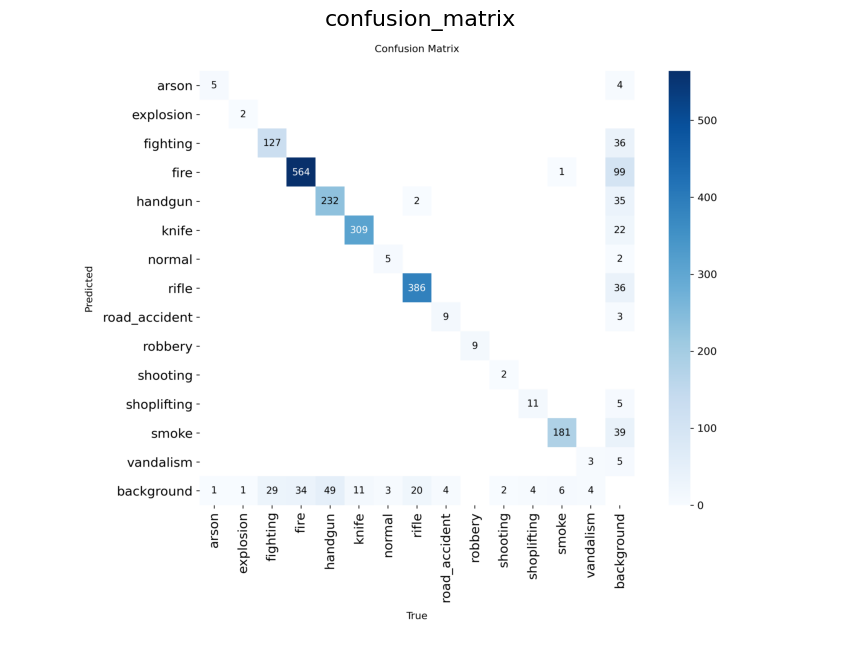

founded: confusion_matrix_normalized.png


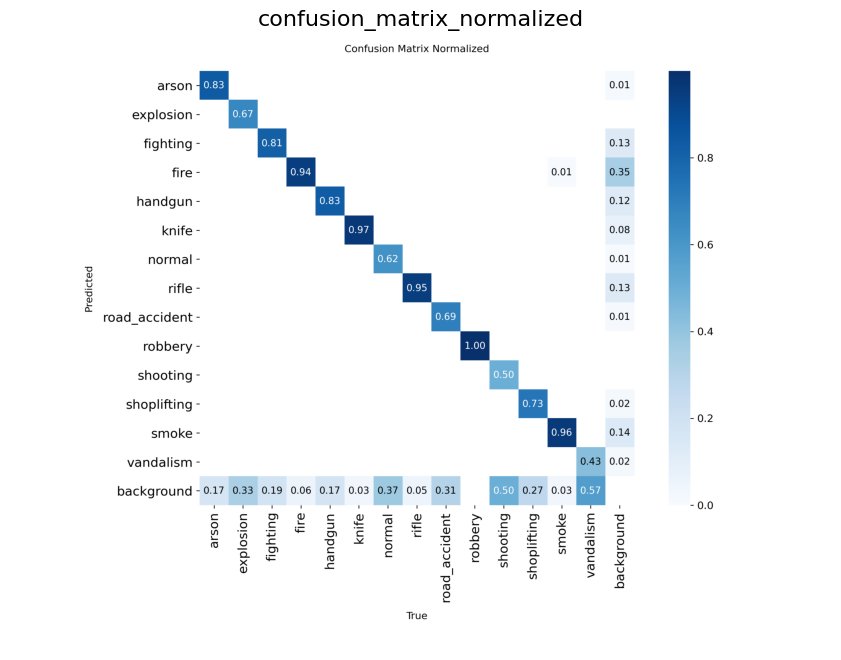

founded: BoxPR_curve.png


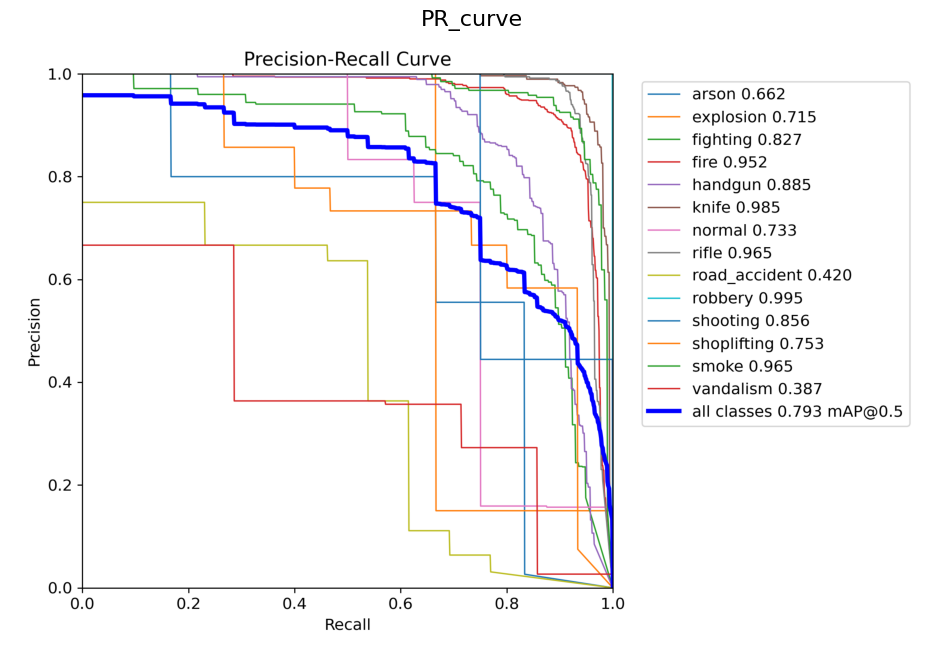

founded: BoxF1_curve.png


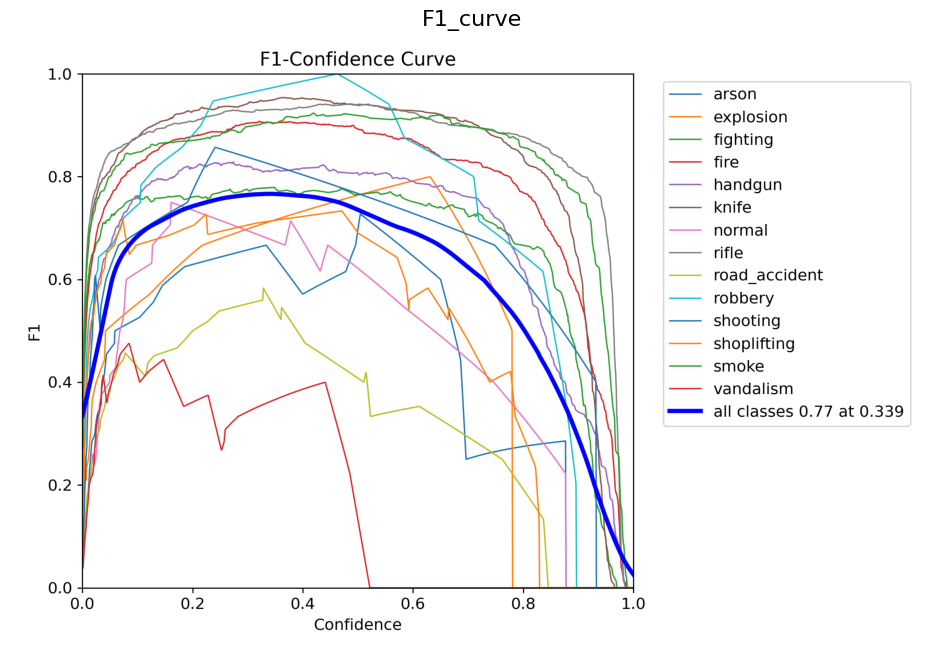

founded: BoxP_curve.png


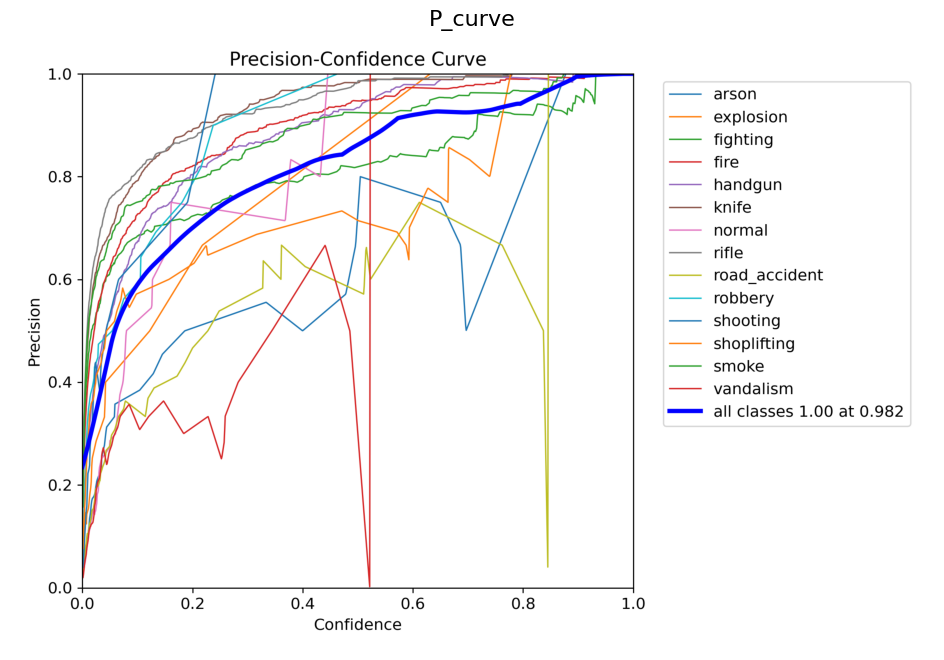

founded: BoxR_curve.png


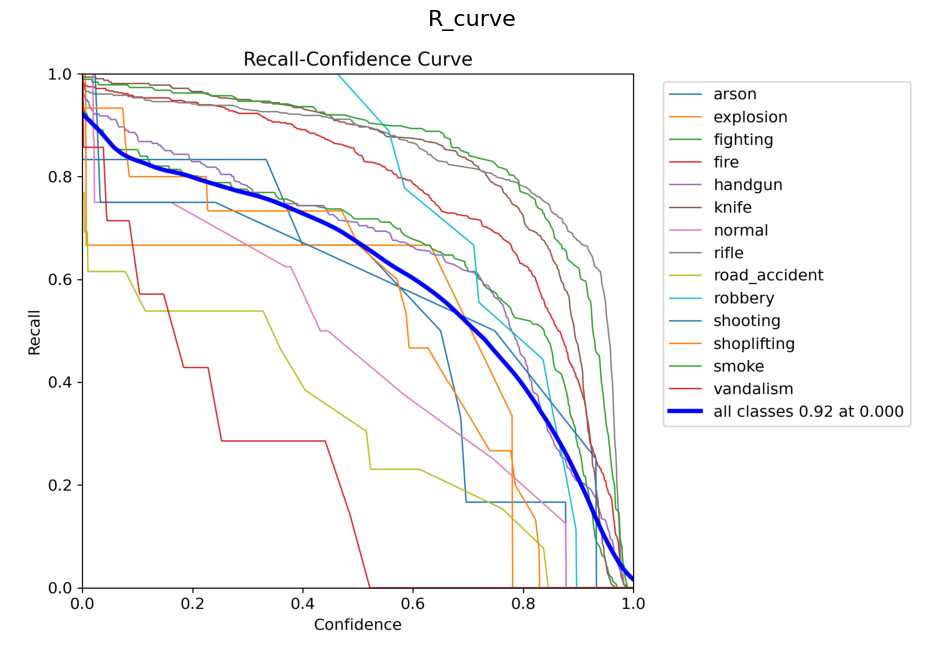

not found : labels.jpg
not found : labels_correlogram.jpg


In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

plot_dir = "/content/runs/val/final_results_with_plots"

plots = [
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
    "BoxPR_curve.png",
    "BoxF1_curve.png",
    "BoxP_curve.png",
    "BoxR_curve.png",
    "labels.jpg",
    "labels_correlogram.jpg"
]

for p in plots:
    path = Path(plot_dir) / p
    if path.exists():
        print(f"founded: {p}")
        img = mpimg.imread(path)
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.title(p.replace(".png","").replace(".jpg","").replace("Box",""), fontsize=16)
        plt.axis('off')
        plt.show()
    else:
        print(f"not found : {p}")